In [26]:
import numpy as np
import matplotlib.pyplot as plt
import random

# inputs: 
# v, an array of payoffs for each action at a given turn
# epsilon, the learning rate
# h, the range of the payoffs
# outputs:
# weights, weights for each action at a given turn
# pi, optimal probabilities for picking each action at a given turn
def exponential_weights(v, epsilon, h):
    V = np.cumsum(v, axis=1)
    weights = np.power((1 + epsilon), V[:, :-1]/h)
    # because we're referencing the previous column, the first
    # column of ones gets removed so we need to add it back
    weights = np.insert(weights, 0, np.ones(v.shape[0]), axis=1)
    pi = np.divide(weights, np.sum(weights, axis=0))
    return weights, pi

# a
def adversarial_fair_payoffs(actions, rounds):
    V = np.zeros(shape=[actions, ])
    payoffs = np.zeros(shape=[actions, rounds])
    for i in range(rounds):
        x = np.random.uniform(0,1)
        j_star = np.argmin(V)
        payoffs[j_star][i] = x
        V[j_star] += x

    return payoffs

#b
def bernoulli_payoffs(actions, rounds):
    probabilities = list(map(lambda a: np.random.uniform(0, 0.5), np.zeros(shape=[actions, ])))
    payoffs = np.zeros(shape=[actions, rounds])
    for i in range(rounds):
        for j in range(actions):
            if np.random.uniform(0, 1) < probabilities[j]:
                payoffs[j][i] = 1
               
    return payoffs

#c
def bulls_data():
    data = np.genfromtxt('BullsData.csv', delimiter=',')
    # remove the dates/player names
    data = np.delete(data, 0, axis=0) 
    data = np.delete(data, -1, axis=0) 
    data = np.delete(data, 0, axis=1)
    
    return data

#d
def poisson_payoffs(actions, rounds):
    return np.array([[1, 1], [1, 1]])

def random_pick(probability_array):
    random_number = random.random()
    cumulative_probability = 0.0
    for index, probability in enumerate(probability_array):
        cumulative_probability += probability
        if random_number < cumulative_probability:
            return index
    return len(probability_array) - 1

def regret(payoffs, EW):
    optimal_sum = 0
    EW_sum = 0
    n = payoffs.shape[1]

    for i in range(n):
        j = np.argmax(payoffs[:, i])
        optimal_sum += payoffs[j][i]
        j_i = random_pick(EW[:, i]) # randomly pick an action according to the EW probabilities
        EW_sum += payoffs[j_i, i]

    # print(1 / n * (optimal_sum-EW_sum))
    return 1 / n * (optimal_sum-EW_sum)

def get_graphs_for_parameters():
    N = 100
    STEP = 250
    END = 10000
    a_rounds_regret = np.zeros(int(END/STEP))
    b_rounds_regret = np.zeros(int(END/STEP))
    actions = 20
    for rounds in range(STEP, END, STEP):
        # average results from N samples
        a_sum = 0
        b_sum = 0
        epsilon = np.power(np.log(actions)/rounds, 1/2)
        for i in range(N):
            a_payoffs = adversarial_fair_payoffs(actions, rounds)
            b_payoffs = bernoulli_payoffs(actions, rounds)
            _, a_EW = exponential_weights(a_payoffs, epsilon, 1)
            _, b_EW = exponential_weights(b_payoffs, epsilon, 1)
            a_sum += regret(a_payoffs, a_EW)
            b_sum += regret(b_payoffs, b_EW)
        a_rounds_regret[int(rounds/STEP)] = a_sum/N
        b_rounds_regret[int(rounds/STEP)] = b_sum/N

    plt.plot(list(range(0, END, STEP)), a_rounds_regret, color="red", label="Adversarial Fair Payoff")
    plt.plot(list(range(0, END, STEP)), b_rounds_regret, color="blue", label="Bernoulli Payoff")
    plt.xlabel('Rounds')
    plt.ylabel('Regret')
    plt.title('Regret vs Rounds')
    plt.legend()
    plt.show()

    STEP = 4
    END = 100
    a_actions_regret = np.zeros(int(END/STEP))
    b_actions_regret = np.zeros(int(END/STEP))
    rounds = 20
    for actions in range(STEP, END, STEP):
        # average results from N samples
        a_sum = 0
        b_sum = 0
        epsilon = np.power(np.log(actions)/rounds, 1/2)
        for _ in range(N):
            a_payoffs = adversarial_fair_payoffs(actions, rounds)
            b_payoffs = bernoulli_payoffs(actions, rounds)
            _, a_EW = exponential_weights(a_payoffs, epsilon, 1)
            _, b_EW = exponential_weights(b_payoffs, epsilon, 1)
            a_sum += regret(a_payoffs, a_EW)
            b_sum += regret(b_payoffs, b_EW)
        a_actions_regret[int(actions/STEP)] = a_sum/N
        b_actions_regret[int(actions/STEP)] = b_sum/N
        
    plt.plot(list(range(0, END, STEP)), a_actions_regret, color="red", label="Adversarial Fair Payoff")
    plt.plot(list(range(0, END, STEP)), b_actions_regret, color="blue", label="Bernoulli Payoff")
    plt.xlabel('Actions')
    plt.ylabel('Regret')
    plt.title('Regret vs Actions')
    plt.legend()
    plt.show()

def analyze_payoffs(step, end):
    N = 100
    regrets = {
        "Adversarial Fair": np.zeros(int(end/step)), 
        "Bernoulli": np.zeros(int(end/step)), 
        "Chicago Bulls": np.zeros(int(end/step)), 
        "Poisson": np.zeros(int(end/step))
    }
    actions = 20
    rounds = 250
    for epsilon in range(0, end, step):
        # average results from N samples
        epsilon = float(epsilon)/100
        # print(epsilon)
        a_sum = 0
        b_sum = 0
        c_sum = 0
        d_sum = 0
        for i in range(N):
            a_payoffs = adversarial_fair_payoffs(actions, rounds)
            b_payoffs = bernoulli_payoffs(actions, rounds)
            c_payoffs = bulls_data()
            d_payoffs = poisson_payoffs(actions, rounds)
            _, a_EW = exponential_weights(a_payoffs, epsilon, 1)
            _, b_EW = exponential_weights(b_payoffs, epsilon, 1)
            _, c_EW = exponential_weights(c_payoffs, epsilon, 44) #44 is the max points scored in the data
            _, d_EW = exponential_weights(d_payoffs, epsilon, 1)
            # if epsilon > 0: 
            #     print(a_EW)
            a_sum += regret(a_payoffs, a_EW)
            b_sum += regret(b_payoffs, b_EW)
            c_sum += regret(c_payoffs, c_EW)
            d_sum += regret(d_payoffs, d_EW)
        regrets["Adversarial Fair"][int(epsilon*100)] = a_sum/N
        regrets["Bernoulli"][int(epsilon*100)] = b_sum/N
        regrets["Chicago Bulls"][int(epsilon*100)] = c_sum/N
        regrets["Poisson"][int(epsilon*100)] = d_sum/N

    return regrets

def plot_regrets(regrets, step, end):
    print(np.argmin(regrets["Adversarial Fair"]), np.min(regrets["Adversarial Fair"]))
    print(np.argmin(regrets["Bernoulli"]), np.min(regrets["Bernoulli"]))
    print(np.argmin(regrets["Chicago Bulls"]), np.min(regrets["Chicago Bulls"]))
    print(np.argmin(regrets["Poisson"]), np.min(regrets["Poisson"]))
    # print(regrets)

    for payoff in regrets.keys():
        plt.plot(np.divide(list(range(0, end, step)), 100), regrets[payoff], label=payoff)
    plt.xlabel('Epsilon')
    plt.ylabel('Regret')
    plt.title('Regret vs Epsilon')
    plt.legend()
    plt.show()

# testing
def test_example_from_class():
    weights, pi = exponential_weights(np.array([[1, 1, 0, 0], [0, 0, 1, 1]]), 1, 1)
    assert np.array_equal(weights, [[1, 2, 4, 4], [1, 1, 1, 2]])
    assert np.array_equal(pi, [[1/2, 2/3, 4/5, 2/3], [1/2, 1/3, 1/5, 1/3]])


In [28]:
def write_dictionary_to_excel(input_dictionary):
    from openpyxl import Workbook

    wb = Workbook()

    for key, arr in input_dictionary.items():
        sheet = wb.create_sheet(title = key)
        for i, row in enumerate(arr):
            for j, col in enumerate(row):
                sheet.cell(row=i+1, column=j+1, value=col)

    wb.save('results.xlsx') 

Test passed
29 0.0
29 0.0
29 0.0
0 0.0
29 0.0
[0.47518494 0.47605347 0.47491069 0.47404414 0.47426308 0.47664236
 0.4752251  0.47622134 0.47749211 0.47480125 0.47626369 0.47865774
 0.47390249 0.47271103 0.47855    0.47621109 0.47562874 0.4791755
 0.47526598 0.47690073 0.47768368 0.47490489 0.47372055 0.47708942
 0.47411563 0.47306275 0.47738101 0.47642062 0.47680424 0.
 0.47762865 0.47621286 0.47620765 0.48145659 0.47843509 0.47721304
 0.47673132 0.47472507 0.47524895 0.47682702 0.47628606 0.47524253
 0.47842196 0.4784301  0.47797847 0.47696363 0.47983237 0.4748386
 0.47835647 0.47981019 0.47667348 0.47709101 0.47861682 0.4755332
 0.47643786 0.47938508 0.48003546 0.47762947 0.         0.47578304
 0.47855507 0.47966719 0.47962626 0.47794197 0.48007279 0.47651841
 0.4752875  0.47686486 0.47931512 0.48195552 0.47909942 0.4798865
 0.47991554 0.4810999  0.47937771 0.4796954  0.47854312 0.48028061
 0.48059909 0.48148968 0.48136802 0.48040428 0.48107339 0.48168322
 0.48079241 0.47928982 0.477

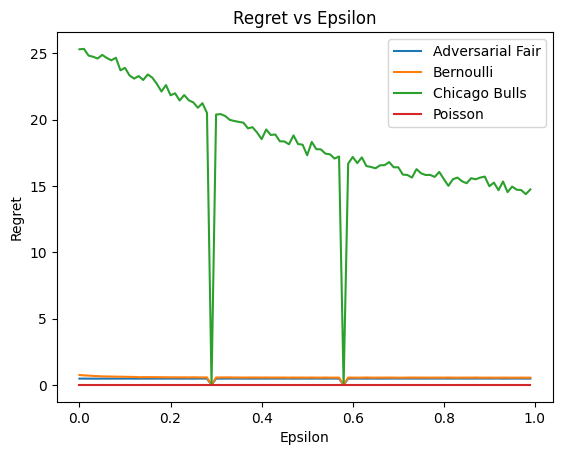

In [27]:
if __name__ == "__main__":
    test_example_from_class()
    print("Test passed")
    
    step = 1
    end = 100
    regrets = analyze_payoffs(step, end)
    

In [ ]:
write_dictionary_to_excel(regrets)
plot_regrets(regrets, step, end)